# QUADRATIC FUNCTION

## import and setup

In [15]:
import numpy as np
from matplotlib import pylab as plt
import optimizers
from importlib import reload

In [2]:
def f(x, args):
    np.random.seed(args['seed'])
    xi = args['sigma'] * np.random.standard_normal(1)
    return 1./2 * x.T @ args['A'] @ x - args['b'].T @ x + xi

def gradient_true(x, args):
    return args['A'] @ x - args['b']

def presearch(set, w_0):
    args['set'] = set
    args['x_0'] = w_0
    w_true_sol, _, _ = optimizers.GDOptimizer(args).search()
    R_0 = f(w_0, args) - f(w_true_sol, args)
    return w_true_sol, R_0

def calculate(args, optimizer, R_0, label, title):
    
    w_sol, errors, times = optimizer.search()
    iterations = range(1, len(errors)+1)
    
    return iterations, errors / R_0, label, times, w_sol

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / args['L']

def momentum_k(k, f, nabla_f, x_k, args):
    return k / (k + 1)

def const_gamma(args):
    return 1. / (args['c'] * args['L'])

def fw_step(args):
    return 2 / (args['k'] + 3)

def momentum_fw(args):
    return (args['k'] + 1) / (args['k'] + 3)


In [21]:
def experiment(Qs, ws_0, Rs_0, ws_sol, linestyles, grads, grad_est_names, colors, methods, method_names):
    
    iterations_exp = []
    errors_exp = []
    labels_exp = []
    linestyles_exp = []
    colors_exp = []
 
    for Q, w_0, R_0, w_sol, linestyle in zip(Qs, ws_0, Rs_0, ws_sol, linestyles):

        args['x_sol'] = w_sol
        args['x_0'] = w_0

        for grad, grad_est_name, color in zip(grads, grad_est_names, colors):

            args['set'] = Q
            args['gradient'] = grad

            for method, method_name in zip(methods, method_names):

                label = f'{method_name}, {grad_est_name}, {Q}'

                iterations, errors, _, _, _ = calculate(args, method(args), R_0, label, title)
                iterations_exp.append(iterations)
                errors_exp.append(errors)
                labels_exp.append(label)
                linestyles_exp.append(linestyle)
                colors_exp.append(color)
                    
    return iterations_exp, errors_exp, labels_exp, linestyles_exp, colors_exp

In [3]:
reload(optimizers)
args = {}
args['d'] = 100
args['mu'] = 1
args['L'] = 1000
args['function'] = f
args['seed'] = 42

args['gamma'] = lambda k: 1 / np.sqrt(k + 1)
args['eps'] = -100
args['sigma'] = 0

args['A'] = optimizers.generate_A(args['d'], args['mu'], args['L'], args['seed'])
np.random.seed(args['seed'])
args['b'] = np.random.random_sample(args['d'])
args['oracle_counter'] = 0
args['oracle_calls'] = []

## Finding x_sol

In [4]:
reload(optimizers)

args['momentum_k'] = momentum_fw
args['max_steps'] = 10 ** 5
args['batch_size'] = 1
args['criterium'] = 'f(x_k+1) - f(x_k)'
args['jaguar'] = False
args['sega'] = False
args['c'] = 50
args['step'] = const_gamma
args['gradient'] = gradient_true

np.random.seed(args['seed'])
w_0 = np.random.random_sample(args['d'])

w_0_l1 = w_0 / np.linalg.norm(w_0, ord=1)
w_0_l2 = w_0 / np.linalg.norm(w_0, ord=2)
w_0_simp = np.abs(w_0) / np.linalg.norm(w_0, ord=1)

args['use_proj'] = True

w_true_sol_l1, R_0_l1 = presearch('l1_ball', w_0_l1)
w_true_sol_l2, R_0_l2 = presearch('l2_ball', w_0_l2)
w_true_sol_simp, R_0_simp = presearch('simplex', w_0_simp)

args['use_proj'] = False

100%|█████████████████████████████████| 100000/100000 [00:34<00:00, 2895.47it/s]


# Different metods

In [22]:
Qs = ['l1_ball', 'l2_ball', 'simplex']
ws_0 = [w_0_l1, w_0_l2, w_0_simp]
Rs_0 = [R_0_l1, R_0_l2, R_0_simp]
ws_sol = [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]
linestyles = ['dashed', 'solid', 'dashdot']
colors = ['red', 'green']

args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['gamma'] = lambda k: 1e-1
args['grad_curr'] = np.zeros(args['d'])

## MBFW

### Setup

In [13]:
reload(optimizers)

args['max_steps'] = 10 ** 4
args['sega'] = True
args['prob'] = 0
args['c'] = 10
args['grad_curr'] = np.zeros(args['d'])
args['h'] = np.zeros(args['d'])
args['step'] = fw_step

grads = [optimizers.get_grad_tpf_jaguar, optimizers.get_grad_opf_jaguar]
grad_est_names = ['TPF', 'OPF']
methods = [optimizers.MBFWOptimizer]
method_names = ['MBFW']

### Exps and Plots

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 3499.34it/s]


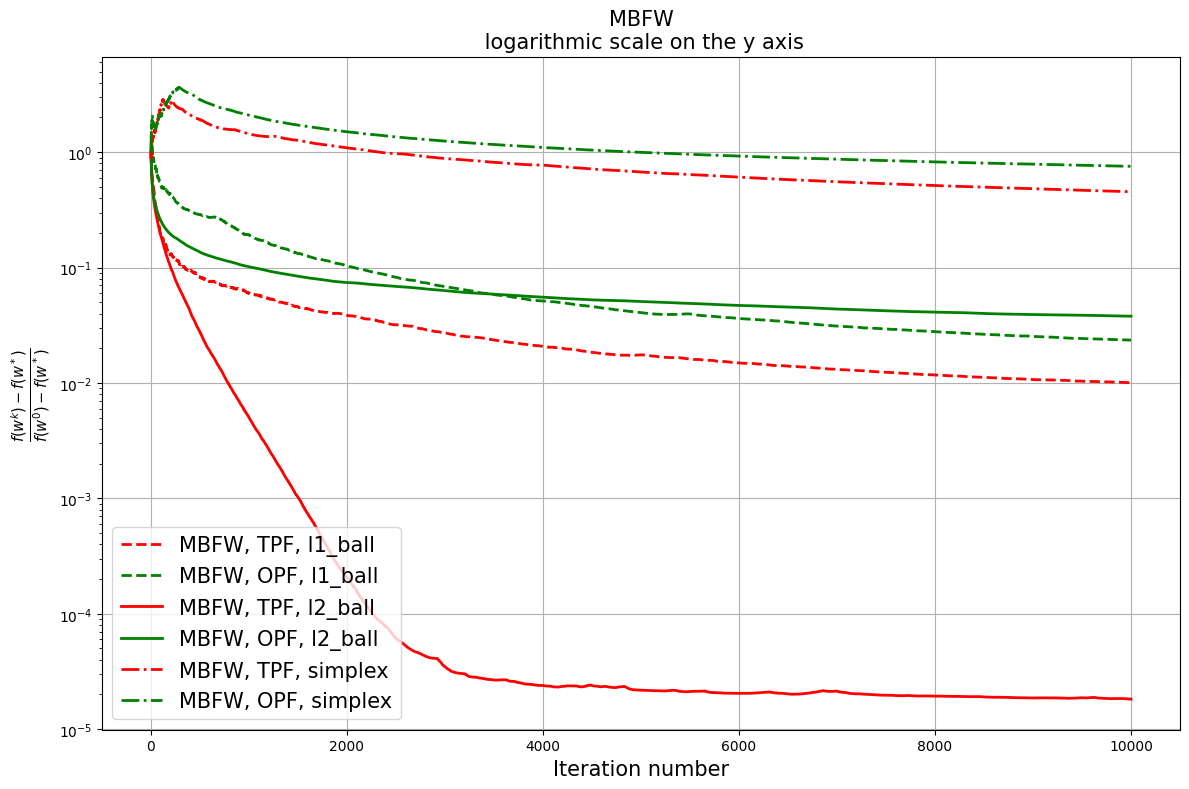

In [14]:
iterations_mbfw, errors_mbfw, labels_mbfw, linestyles_mbfw, colors_mbfw = \
experiment(Qs, ws_0, Rs_0, ws_sol, linestyles, grads, grad_est_names, colors, methods, method_names)

title = "MBFW"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_mbfw, errors_mbfw, y_label=y_label,
                         labels=labels_mbfw, title=title, markers=[None]*100, 
                         linestyles=linestyles_mbfw, colors=colors_mbfw)

## FW

### setup

In [16]:
reload(optimizers)

args['max_steps'] = 10 ** 4
args['jaguar'] = True
args['prob'] = 1e-3
args['grad_curr'] = np.zeros(args['d'])
args['step'] = fw_step

grads = [optimizers.get_grad_tpf_jaguar, optimizers.get_grad_opf_jaguar]
grad_est_names = ['TPF', 'OPF']
methods = [optimizers.FWOptimizer]
method_names = ['FW']

### exps and plots

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 5382.11it/s]


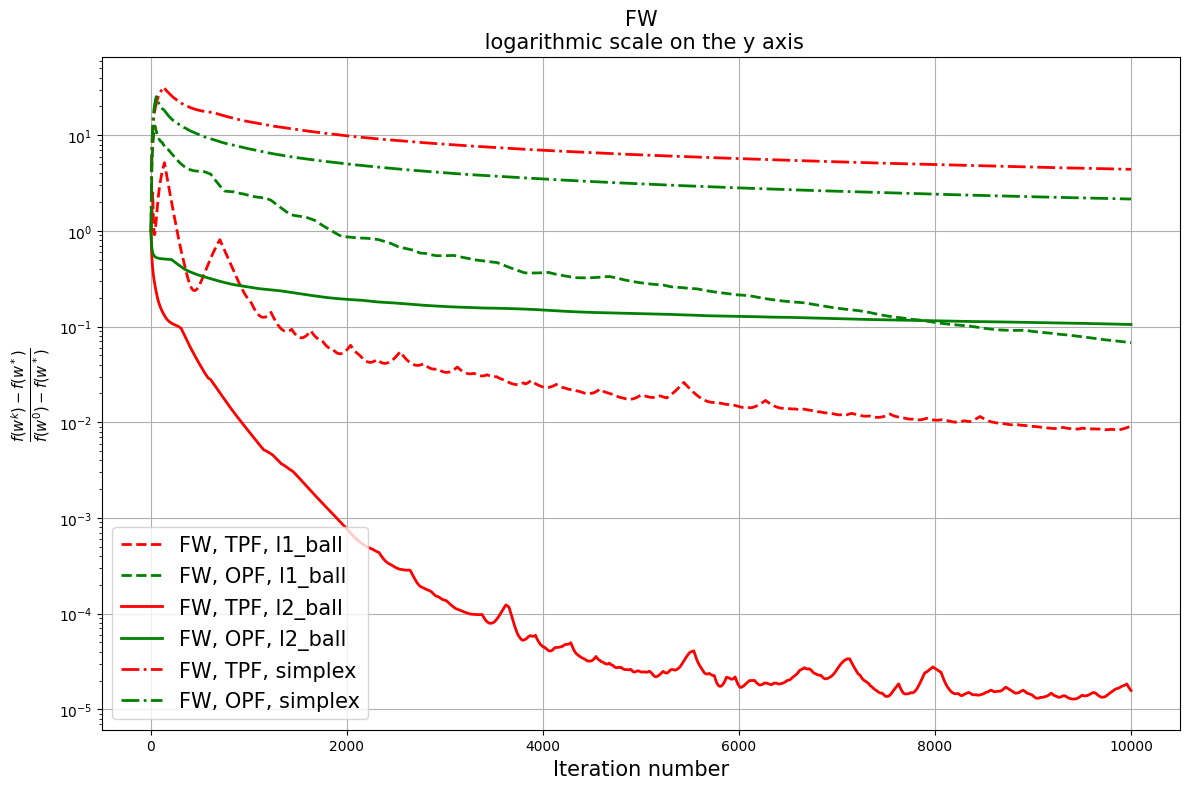

In [17]:
iterations_fw, errors_fw, labels_fw, linestyles_fw, colors_fw = \
experiment(Qs, ws_0, Rs_0, ws_sol, linestyles, grads, grad_est_names, colors, methods, method_names)

title = "FW"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fw, errors_fw, y_label=y_label,
                         labels=labels_fw, title=title, markers=[None]*100, 
                         linestyles=linestyles_fw, colors=colors_fw)

## Projection

### setup

In [19]:
reload(optimizers)

args['max_steps'] = 10 ** 3
args['use_proj'] = True
args['jaguar'] = True
args['prob'] = 1e-3
args['step'] = const_gamma
args['c'] = 100

grads = [optimizers.get_grad_tpf_jaguar, optimizers.get_grad_opf_jaguar]
grad_est_names = ['TPF', 'OPF']
methods = [optimizers.GDOptimizer]
method_names = ['Proj']

### exps and plots

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3068.01it/s]


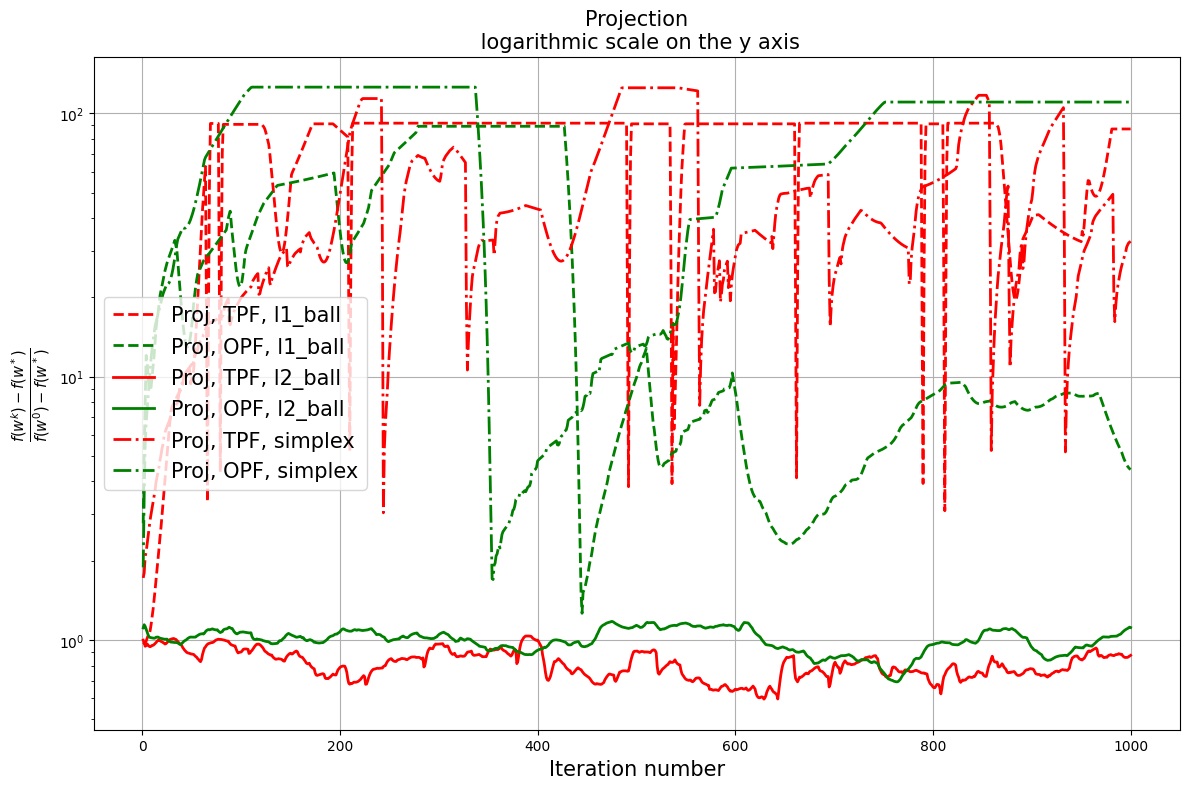

In [20]:
iterations_proj, errors_proj, labels_proj, linestyles_proj, colors_proj = \
experiment(Qs, ws_0, Rs_0, ws_sol, linestyles, grads, grad_est_names, colors, methods, method_names)

title = "Projection"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_proj, errors_proj, y_label=y_label,
                         labels=labels_proj, title=title, markers=[None]*100, 
                         linestyles=linestyles_proj, colors=colors_proj)

# Different gradient methods 

## MBFW TPF

### setup

In [27]:
reload(optimizers)

args['max_steps'] = 10 ** 4
args['use_proj'] = False
args['sega'] = False
args['norm'] = 1
args['prob'] = 0
args['step'] = fw_step

grads = [optimizers.get_grad_tpf_jaguar, optimizers.get_grad_tpf_lame_v1]
grad_est_names = ['TPF SEGA', 'TPF lame']
methods = [optimizers.MBFWOptimizer]
method_names = ['MBFW']

### exps and plots

100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 2684.38it/s]


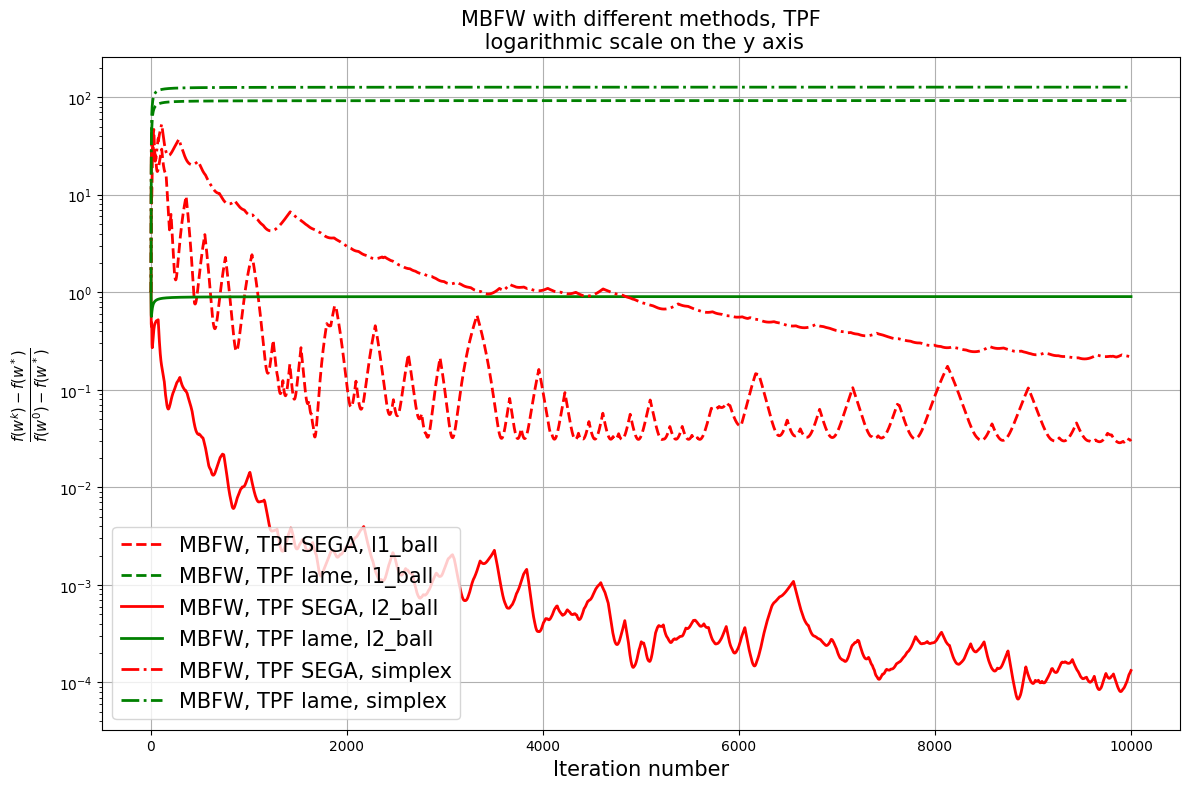

In [28]:
iterations_mbfw, errors_mbfw, labels_mbfw, linestyles_mbfw, colors_mbfw = \
experiment(Qs, ws_0, Rs_0, ws_sol, linestyles, grads, grad_est_names, colors, methods, method_names)

title = "MBFW with different methods, TPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_mbfw, errors_mbfw, y_label=y_label,
                         labels=labels_mbfw, title=title, markers=[None]*100,
                         name='MBFW TPF cmp exp1', 
                         linestyles=linestyles_mbfw, colors=colors_mbfw)

## FW TPF

### setup

In [29]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['use_proj'] = False
args['norm'] = 1
args['prob'] = 1e-1

grads = [optimizers.get_grad_tpf_jaguar, optimizers.get_grad_tpf_lame_v1]
grad_est_names = ['TPF SEGA', 'TPF lame']
methods = [optimizers.FWOptimizer]
method_names = ['FW']

### exps and plots

100%|████████████████████████████████████| 10000/10000 [00:17<00:00, 561.48it/s]


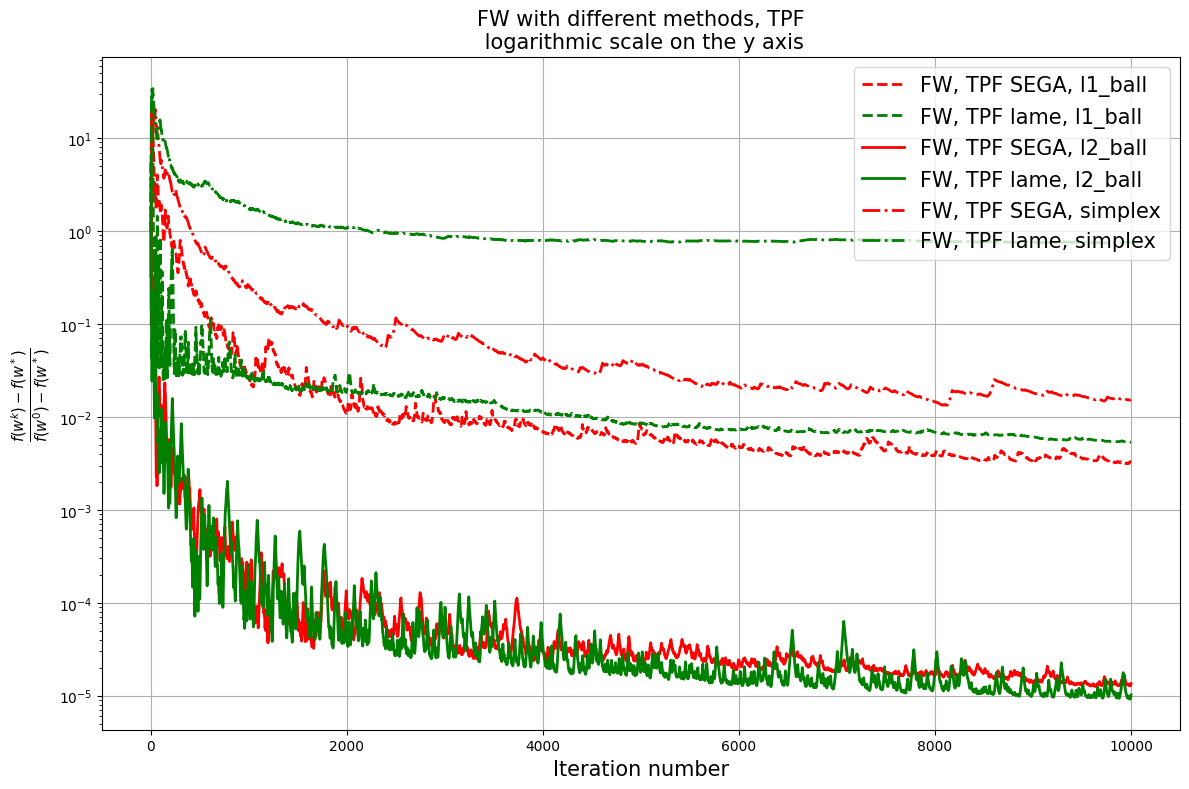

In [30]:
iterations_fw, errors_fw, labels_fw, linestyles_fw, colors_fw = \
experiment(Qs, ws_0, Rs_0, ws_sol, linestyles, grads, grad_est_names, colors, methods, method_names)

title = "FW with different methods, TPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fw, errors_fw, y_label=y_label,
                         labels=labels_fw, title=title, markers=[None]*100,
                         name='FW TPF cmp exp1', 
                         linestyles=linestyles_fw, colors=colors_fw)

## Projection TPF

### setup

In [31]:
reload(optimizers)

args['max_steps'] = 2 * 10 ** 3
args['use_proj'] = True
args['norm'] = 1
args['c'] = 200
args['grad_curr'] = np.zeros(args['d'])

grads = [optimizers.get_grad_tpf_jaguar, optimizers.get_grad_tpf_lame_v1]
grad_est_names = ['TPF SEGA', 'TPF lame']
methods = [optimizers.GDOptimizer]
method_names = ['Proj']

### exps and plots

100%|██████████████████████████████████████| 2000/2000 [00:03<00:00, 603.85it/s]


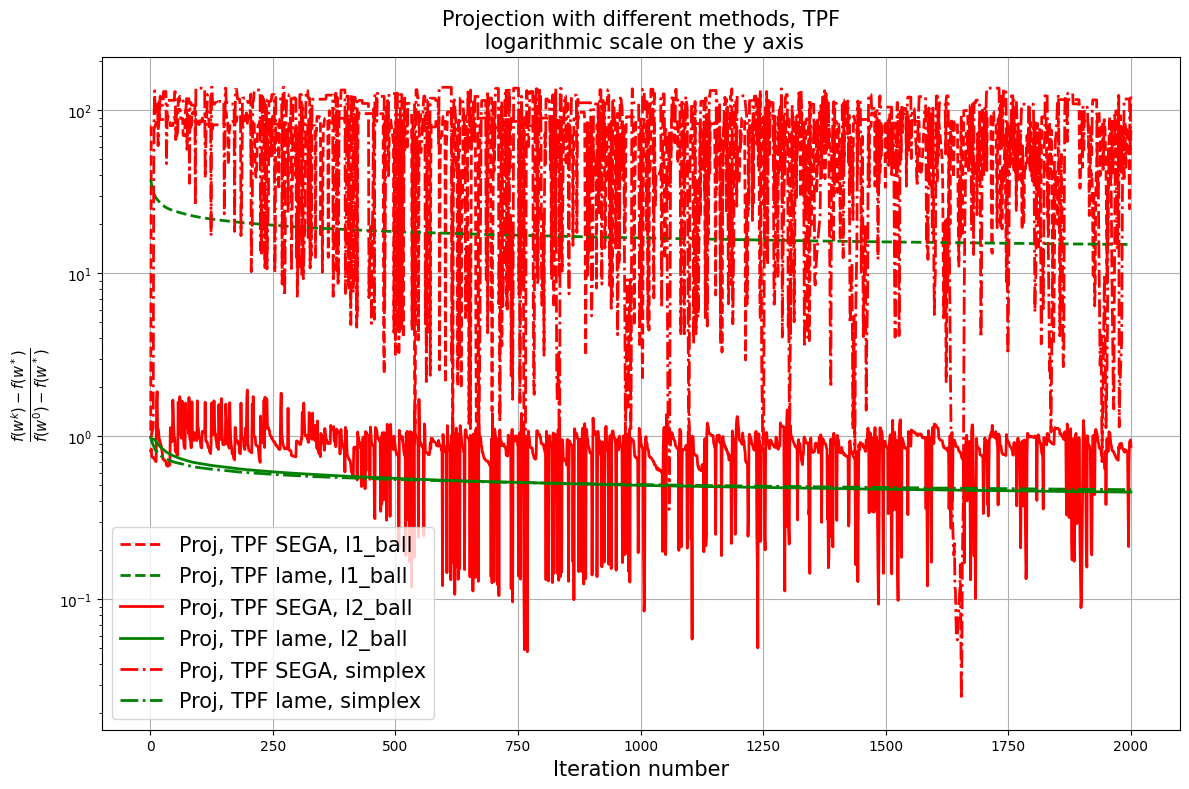

In [32]:
iterations_proj, errors_proj, labels_proj, linestyles_proj, colors_proj = \
experiment(Qs, ws_0, Rs_0, ws_sol, linestyles, grads, grad_est_names, colors, methods, method_names)

title = "Projection with different methods, TPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_proj, errors_proj, y_label=y_label,
                         labels=labels_proj, title=title, markers=[None]*100,
                         name='Proj TPF cmp exp1', 
                         linestyles=linestyles_proj, colors=colors_proj)

## MBFW OPF

### setup

In [35]:
reload(optimizers)

args['max_steps'] = 10 ** 4
args['use_proj'] = False
args['norm'] = 1
args['prob'] = 1e-1
args['grad_curr'] = np.zeros(args['d'])

grads = [optimizers.get_grad_opf_jaguar, optimizers.get_grad_opf_lame]
grad_est_names = ['OPF SEGA', 'OPF lame']
methods = [optimizers.MBFWOptimizer]
method_names = ['MBFW']

### exps and plots

100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 905.70it/s]


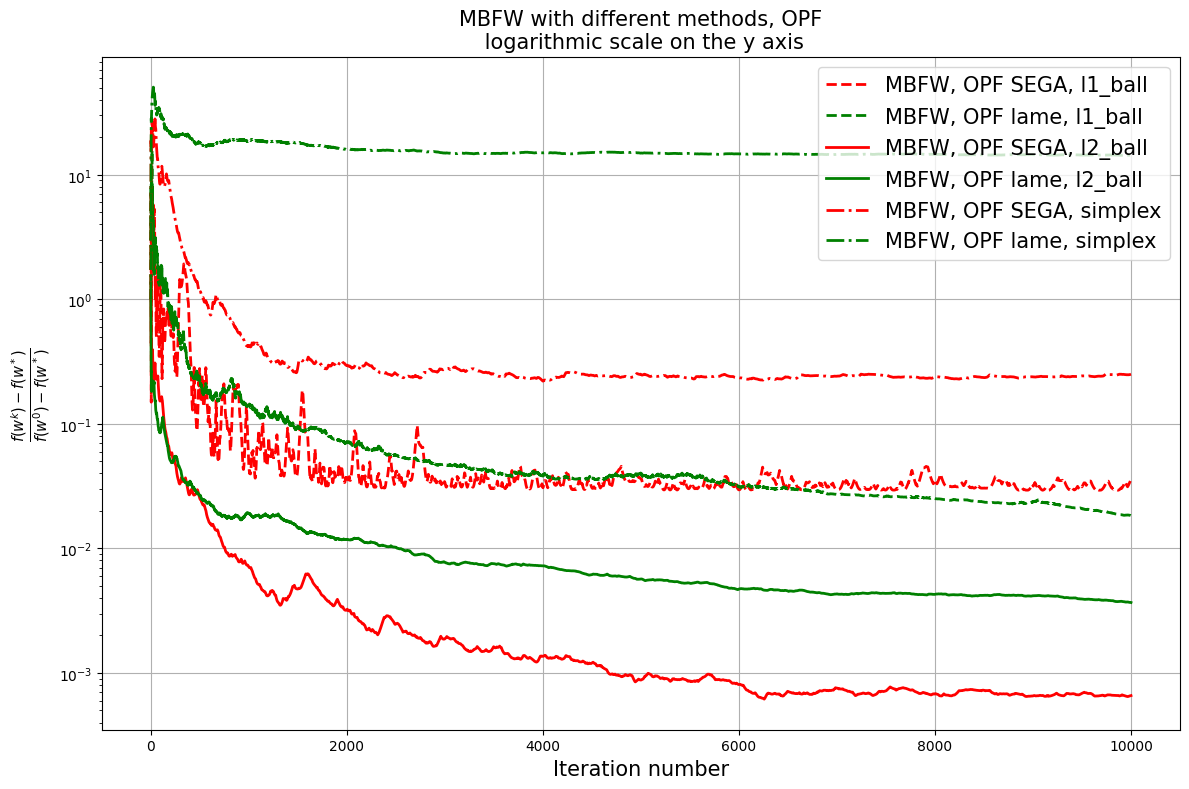

In [36]:
iterations_mbfw, errors_mbfw, labels_mbfw, linestyles_mbfw, colors_mbfw = \
experiment(Qs, ws_0, Rs_0, ws_sol, linestyles, grads, grad_est_names, colors, methods, method_names)

title = "MBFW with different methods, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_mbfw, errors_mbfw, y_label=y_label,
                         labels=labels_mbfw, title=title, markers=[None]*100,
                         name='MBFW OPF cmp exp1', 
                         linestyles=linestyles_mbfw, colors=colors_mbfw)

## FW OPF

### setup

In [37]:
reload(optimizers)

args['max_steps'] = 10 ** 4
args['use_proj'] = False
args['norm'] = 1
args['prob'] = 1e-1
args['grad_curr'] = np.zeros(args['d'])

grads = [optimizers.get_grad_opf_jaguar, optimizers.get_grad_opf_lame]
grad_est_names = ['OPF SEGA', 'OPF lame']
methods = [optimizers.FWOptimizer]
method_names = ['FW']

### exps and plots

100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 780.50it/s]


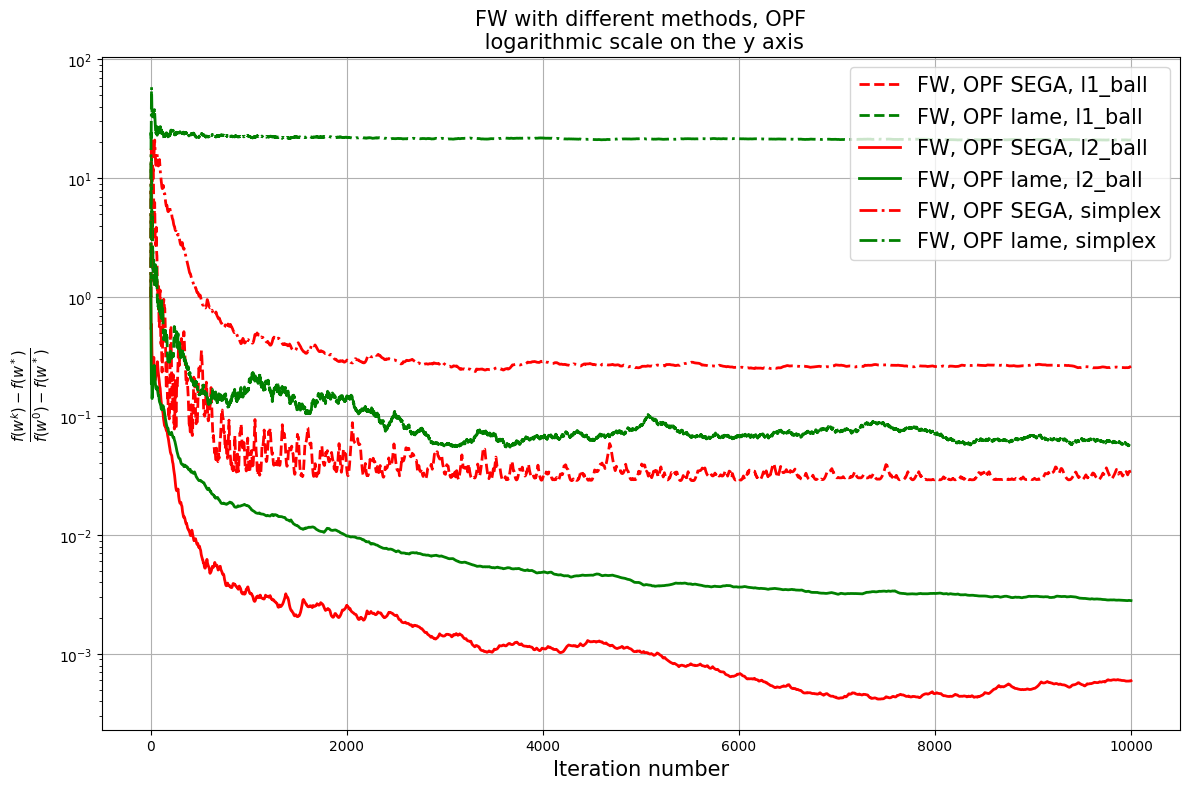

In [38]:
iterations_fw, errors_fw, labels_fw, linestyles_fw, colors_fw = \
experiment(Qs, ws_0, Rs_0, ws_sol, linestyles, grads, grad_est_names, colors, methods, method_names)

title = "FW with different methods, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fw, errors_fw, y_label=y_label,
                         labels=labels_fw, title=title, markers=[None]*100,
                         name='FW OPF cmp exp1', 
                         linestyles=linestyles_fw, colors=colors_fw)

## Projection OPF

### setup

In [41]:
reload(optimizers)

args['max_steps'] = 10 ** 3
args['use_proj'] = True
args['norm'] = 1
args['c'] = 300
args['prob'] = 1e-1

grads = [optimizers.get_grad_opf_jaguar, optimizers.get_grad_opf_lame]
grad_est_names = ['OPF SEGA', 'OPF lame']
methods = [optimizers.GDOptimizer]
method_names = ['Proj']

### exps and plots

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 802.36it/s]


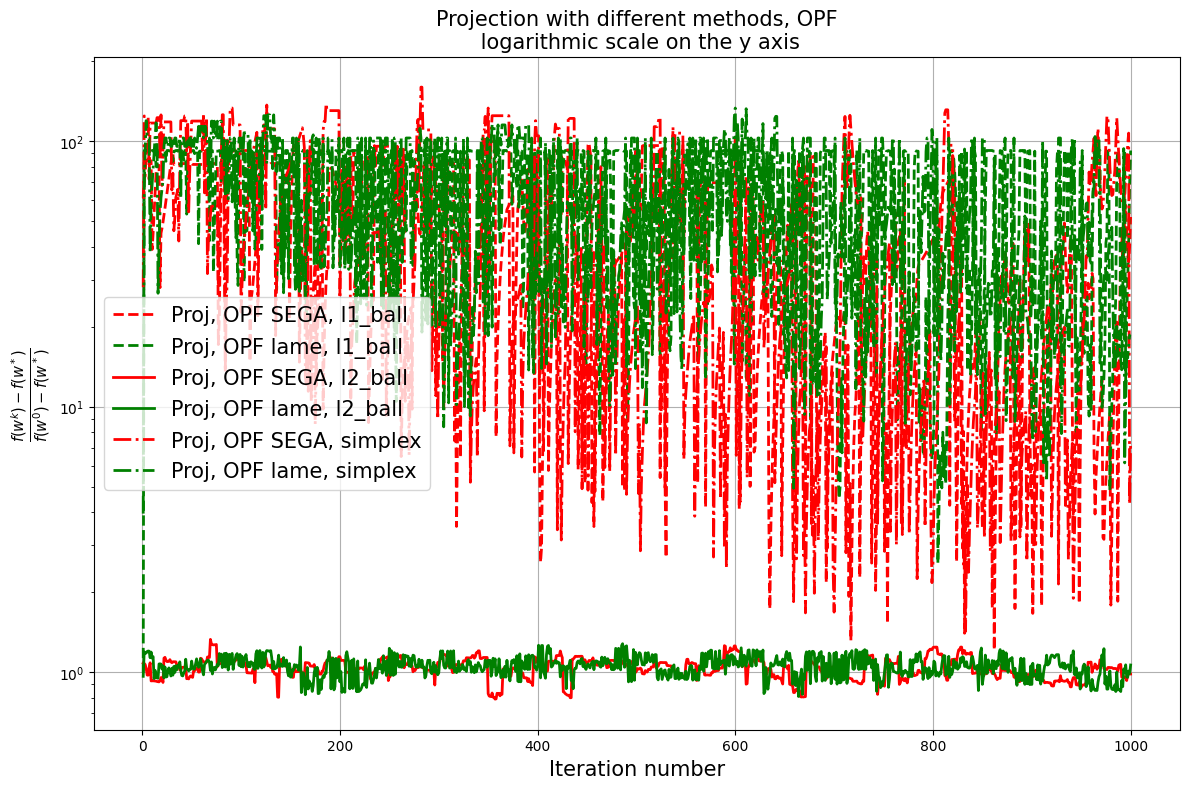

In [42]:
iterations_proj, errors_proj, labels_proj, linestyles_proj, colors_proj = \
experiment(Qs, ws_0, Rs_0, ws_sol, linestyles, grads, grad_est_names, colors, methods, method_names)

title = "Projection with different methods, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_proj, errors_proj, y_label=y_label,
                         labels=labels_proj, title=title, markers=[None]*100,
                         name='Proj OPF cmp exp1',
                         linestyles=linestyles_proj, colors=colors_proj)